This repository contains functionality to get the data of past Lotto draws and drawday statistics and to create a database. In addition, it contains functions for an analysis of preferred numbers and a maximization of the expectation value.  
To run every function of this repository, the following additional python modules are needed:  
pandas, numpy, matplotlib, sklearn.ensemble, treeinterpreter, requests, json, sqlite3, datetime.

# Lotto 6 aus 49 - maximizing the expectation value

The main factor to win in a lottery like *6 aus 49* (6 out of 49) is luck. The probability to win more than having bet is quite low. As only half of one drawdays stake is distributed to the winners, the expectation value is far below 1.
The distributed amount in each winning class (n correct numbers [+ Superzahl]) is a fixed proportion of the stake. As this amount is equally distributed among all winners, the expectation value can be slightly influenced by trying to get into a winning class with few other winners. For *Lotto 6 aus 49*, that means to pick numbers which are not commonly ticked.  
There exist some hints for that strategy in the web such as avoiding lucky numbers (3, 7, 9) and common numbers in dates (1-12, 1-31, 19). But (of course) I could not find first-hand statistics on the actual preferences of the lottery players.  
However, lotto.de delivers the history of all drawn numbers, the stake of each drawday and the number of winners in each winning class. With these data, an estimation of the player's preferences can be done. 
These data are captured and saved to a local database with the appropriate function in the lotto module:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors
import matplotlib.patches as patches
import numpy as np
import lotto
lotto.updateDatabase()

2018-03-14
2018-03-17
2018-03-21
2018-03-24
database updated


First, a single value for the *popularity* of a set of drawn numbers is calculated. As this value rises with a lower popularity, it will be called *unpopularity*.  
The unpopularity is the ratio of the expected number of winners in a winning class to the actual number of winners (**nWin**).  
The expected number of winners is given by the winning **prob**ability multiplied by the number of participants (bets), which is directly proportional to the drawdays **stake** (stake / **costs** per bet).
$$unpopularity=\frac{prob \cdot stake}{nWin \cdot costs}$$
The unpopularity is calculated in three different categories: 
- at least 3 correct numbers
- at least 4 correct numbers
- at least 5 correct numbers

All categories are regardless of the drawn Superzahl and do not exactly match the winning classes.

## Single number analysis
First, the "impact" of a single number is analysed.  
The impact of a number is a naive singlevalue measure indicating a higher (values above 0) or lower winning value per class when this number is drawn. Therefore, the impact of a number is the ratio of the mean unpopularity of all draws that include this number to the mean unpopularity of all draws that do not include this number. Last, 1 is substracted, to have the impact value spread around zero instead of one. Thus we can speak of positive and negative impact.  
The lotto module provides functions for this calculation.

In [2]:
numbersImpact = lotto.getNumbersImpact(normalize=False)
szImpact = lotto.getSzImpact(normalize=False)

The following plot shows the mean of the impact of each number over the three categories (at least 3, 4 and 5 correct numbers, regardless of the Superzahl) and the impact of the Superzahl. 

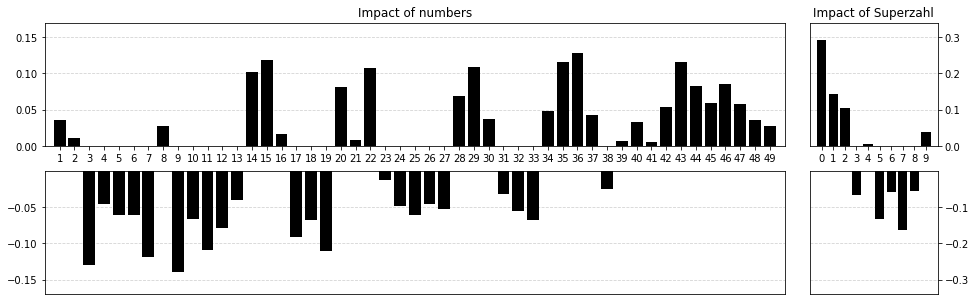

In [3]:
fig = plt.figure(figsize=(16,5))

# numbers with positive impact
upper = plt.subplot2grid((2, 6), (0, 0), colspan=5)
plt.title("Impact of numbers")
plt.bar(range(1,50), numbersImpact, color='k')
plt.axis([0,50, 0,0.17])
plt.xticks(range(1,50))
plt.yticks([0, 0.05, 0.1, 0.15])
upper.set_axisbelow(True)
upper.yaxis.grid(color='lightgray', linestyle='dashed')

# numbers with negative impact
lower = plt.subplot2grid((2, 6), (1, 0), colspan=5)
plt.bar(range(1,50), numbersImpact, color='k')
plt.axis([0,50, -0.17,0])
plt.xticks([])
plt.yticks([-0.05, -0.1, -0.15])
lower.set_axisbelow(True)
lower.yaxis.grid(color='lightgray', linestyle='dashed')

# Superzahl with positive impact
upperSz = plt.subplot2grid((2, 6), (0, 5))
plt.title("Impact of Superzahl")
plt.bar(range(0,10), szImpact, color='k')
plt.axis([-1,10, 0, 0.34])
plt.xticks(range(0,10))
plt.yticks([0, 0.1, 0.2, 0.3])
upperSz.yaxis.tick_right()
upperSz.set_axisbelow(True)
upperSz.yaxis.grid(color='lightgray', linestyle='dashed')

# Superzahl with negative impact
lowerSz = plt.subplot2grid((2, 6), (1, 5))
plt.bar(range(0,10), szImpact, color='k')
plt.axis([-1 ,10, -0.34,0])
plt.xticks([])
plt.yticks([-0.1, -0.2, -0.3])
lowerSz.yaxis.tick_right()
lowerSz.set_axisbelow(True)
lowerSz.yaxis.grid(color='lightgray', linestyle='dashed')

This plot confirms the common strategy recommendations: lucky numbers like 3, 7 and 9 lead to lower winnings as they are commonly picked. Also, choosing numbers below 32 reduces lottery winnings. This agrees with the assumption that people tend to pick numbers of dates.  
To get an idea of patterns or positions of commonly chosen numbers, the following plot arranges the numbers according to the original lottery ticket with coloured impact.

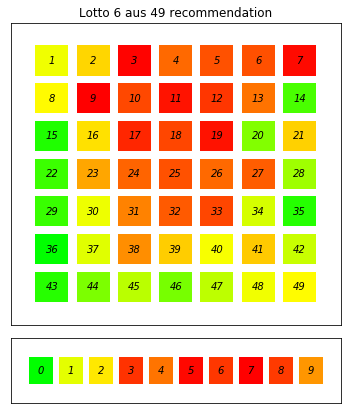

In [4]:
numbersImpactNormalized = lotto.getNumbersImpact()
szImpactNormalized = lotto.getSzImpact()

# function to add single field
def addRect(axis, x, y, l, number, relImpact):
    color = matplotlib.colors.hsv_to_rgb((0.333 * np.power(relImpact,1.5), 1, 1))
    axis.add_patch(patches.Rectangle((x-l/2, y-l/2),l,l,facecolor=color))
    axis.text(x, y, str(number), horizontalalignment = 'center', verticalalignment='center', fontstyle='oblique')

fig = plt.figure(figsize=(9,7))

# plot numbers (1-49)
axisNumbers = plt.subplot2grid((5, 6), (0, 1), rowspan=4, colspan=4)
plt.title("Lotto 6 aus 49 recommendation")
for i in range(0,49):
    x = i % 7 + 1
    y = 7 - int(i / 7)
    addRect(axisNumbers, x, y, 0.8, i+1, (numbersImpact[i] - np.min(numbersImpact)) / (np.max(numbersImpact) - np.min(numbersImpact)))

plt.axis([0,8,0,8])
plt.xticks([])
plt.yticks([])

# plot Superzahl
axisSz = plt.subplot2grid((5, 6), (4, 1), rowspan=2, colspan=4)
for i in range(0,10):
    x = i
    y = 1
    addRect(axisSz, x, y, 0.8, i, (szImpact[i] - np.min(szImpact)) / (np.max(szImpact) - np.min(szImpact)))
plt.axis([-1,10,0,2])
plt.xticks([])
plt.yticks([])
plt.show()


These results regard the impact of single numbers only. They contain no direct information about commonly played combinations (pairs, triplets...). 
Although calculating the impact of pairs might roughly work with the approach described above (each pair was drawn at least 7 times, 22 times on average), the underlying data is incomplete for triplets as not every possible combination was actually drawn since 2002.

## Random Forest Regressor
To still develop a model including as much information as possible, a random forest regressor was trained with the unpopularity values of the single draws. A random forest should be capable of capturing connections between numbers.

In [5]:
from sklearn.ensemble import RandomForestRegressor

# prepare random forest regressor
forestNumbers = RandomForestRegressor(n_estimators=550, max_depth=27, n_jobs=4, oob_score=True)

# get lottodata in prepared pandas dataframes (dummy variables)
numbers, unpopularity = lotto.prepareNumbersAnalysis()

# train forest
forestNumbers.fit(numbers.values, unpopularity.values)

# print oob error fpr each category
print("oob score:")
print(forestNumbers.oob_score_)

print("\noob mean absolute error in categories:")
print("5 correct numbers: {0:4.3f}".format(np.mean(np.abs((forestNumbers.oob_prediction_ - unpopularity)))[0]))
print("4 correct numbers: {0:4.3f}".format(np.mean(np.abs((forestNumbers.oob_prediction_ - unpopularity)))[1]))
print("3 correct numbers: {0:4.3f}".format(np.mean(np.abs((forestNumbers.oob_prediction_ - unpopularity)))[2]))


oob score:
0.52578455853

oob mean absolute error in categories:
5 correct numbers: 0.223
4 correct numbers: 0.123
3 correct numbers: 0.067


Of note, the overall oob score is not very promising. However, the mean absolute errors in each category indicate that the quality differs between the categories. The prediction of the unpopularity of the lower winning classes (3 correct numbers) are much better.  
For comparing the results of the random forest regressor with the simple mean impact analysis, the impact of each number on the random forest model is analysed using treeinterpreter. As the treeinterpreter can only interpret singlelabel trees, an individual forest is trained for each category.

In [6]:
from treeinterpreter import treeinterpreter as ti

forestNumbers5 = RandomForestRegressor(n_estimators=550, max_depth=27, n_jobs=4, oob_score=True)
forestNumbers4 = RandomForestRegressor(n_estimators=550, max_depth=27, n_jobs=4, oob_score=True)
forestNumbers3 = RandomForestRegressor(n_estimators=550, max_depth=27, n_jobs=4, oob_score=True)

forestNumbers5.fit(numbers.values, unpopularity.values[:,0])
forestNumbers4.fit(numbers.values, unpopularity.values[:,1])
forestNumbers3.fit(numbers.values, unpopularity.values[:,2])

prediction5, bias5, impactForest5 = ti.predict(forestNumbers5, numbers.values)
prediction4, bias4, impactForest4 = ti.predict(forestNumbers4, numbers.values)
prediction3, bias3, impactForest3 = ti.predict(forestNumbers3, numbers.values)

trained.


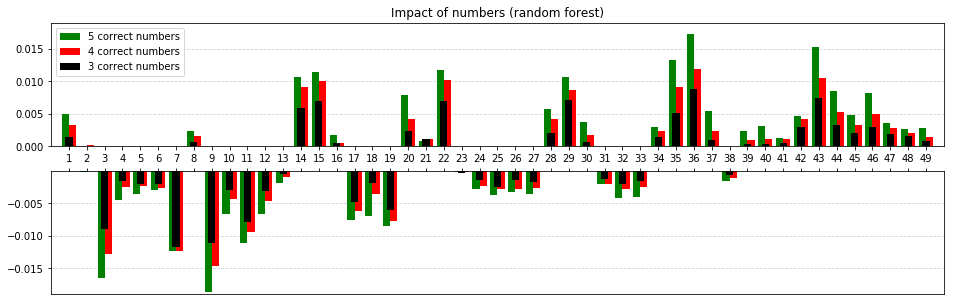

In [7]:
plt.figure(figsize=(16,5))

# positive impact
upper = plt.subplot(211)
plt.bar(np.array(range(1,50))-0.2, (impactForest5 * numbers.values).mean(axis=0), width=0.4, label= "5 correct numbers", color='g')
plt.bar(np.array(range(1,50))+0.2, (impactForest4 * numbers.values).mean(axis=0), width=0.4, label = "4 correct numbers", color='r')
plt.bar(range(1,50), (impactForest3 * numbers.values).mean(axis=0), width=0.4, label="3 correct numbers", color='k')

plt.title("Impact of numbers (random forest)")
plt.axis([0,50, 0, 0.019])
plt.xticks(range(1,50))
upper.set_axisbelow(True)
upper.yaxis.grid(color='lightgray', linestyle='dashed')
plt.legend()

# negative impact
lower = plt.subplot(212)
plt.bar(np.array(range(1,50))-0.2, (impactForest5 * numbers.values).mean(axis=0), width=0.4, label= "5 correct numbers", color='g')
plt.bar(np.array(range(1,50))+0.2, (impactForest4 * numbers.values).mean(axis=0), width=0.4, label = "4 correct numbers", color='r')
plt.bar(range(1,50), (impactForest3 * numbers.values).mean(axis=0), width=0.4, label="3 correct numbers", color='k')

plt.axis([0,50, -0.019, 0])
plt.yticks([-0.005, -0.01, -0.015])
plt.xticks(range(1,50))
lower.set_xticklabels([])
lower.set_axisbelow(True)
lower.xaxis.set_ticks_position('top')
lower.yaxis.grid(color='lightgray', linestyle='dashed')

Due to different models, the values of the impacts differ between the random forest models and the former analysis, but the relative weights are very similar. This indicates a general robustness of both approaches.   
Focussing on the random forest models only, their relative weights do match with small differences in amplitude. As the model in category '3 correct numbers' has the more balanced underlying dataset (most hits in this category), it can be assumed to deliver the most accurate predictions (also seen in oob mean absolute errors above).  
  
To unveil further information hidden in the random forest model, this repository includes a function to pick the best combination of 6 numbers out of a larger set of individually preferred lucky numbers. This ensures a good compromise between personal lucky numbers and a good expecation value. Therefore, for each combiation of the set of input numbers the unpolularity value is predicted using the random forest model, and the best combination is returned for each category. Due to computational limitations, the maximum number of input numbers is limited to 13. 


In [8]:
(best3, best4, best5) = lotto.pick6([15, 16, 29, 36, 35, 14, 20, 4, 47, 30, 2, 22])

print("recommended numbers based on data in categories:")
print("5 correct numbers: " + str(best5))
print("4 correct numbers: " + str(best4))
print("3 correct numbers: " + str(best3))

recommended numbers based on data in categories:
5 correct numbers: [15 22 29 30 35 36]
4 correct numbers: [14 15 20 22 35 36]
3 correct numbers: [14 15 20 22 35 47]


The returned selection differs from just selecting the numbers with highest impact, indicating a more complex model using the random forest regressor. Whether the model is also more accurate, time will tell when the specific combinations are drawn.  

  
# Eurojackpot - maximizing the expectation value
For international players preferring Eurojackpot, an analogous analysis is described below.